In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from modules.plotting_scripts import plot_surprisals, get_avg_df, plot_avg_pos_neg

In [2]:
import numpy as np
from sklearn.linear_model import LinearRegression
from collections import defaultdict

def trend_categories(df, first_step=True):

    def determine_trend(values):
        X = np.arange(len(values)).reshape(-1, 1)
        model = LinearRegression().fit(X, values)
        slope = model.coef_[0]
        return 'Increasing' if slope > 0 else 'Decreasing'

    categories = defaultdict(lambda: [0, []])

    if not first_step:
        df = df[df['Steps'] != 0]
        
    grouped = df.groupby('Token')
    
    for word, word_data in grouped:
        surprisal_values = word_data['MeanSurprisal'].values.reshape(-1, 1)
        antisurprisal_values = word_data['MeanNegSurprisal'].values.reshape(-1, 1)
        
        surprisal_trend = determine_trend(surprisal_values)
        antisurprisal_trend = determine_trend(antisurprisal_values)
        
        key = f"{surprisal_trend}-{antisurprisal_trend}"
        categories[key][0] += 1
        categories[key][1].append(word)
    
    return categories


In [3]:
path = '../results/indiv_surprisals_full.tsv'
indiv_surprisals = pd.read_csv(path, delimiter='\t')

indiv_surprisals = indiv_surprisals.assign(
    MeanSurprisal=indiv_surprisals.groupby(['Steps', 'Token'])['Surprisal'].transform('mean'),
    MeanNegSurprisal=indiv_surprisals.groupby(['Steps', 'Token'])['NegSurprisal'].transform('mean')
)

indiv_surprisals

,Steps,Token,Context,Surprisal,NegSurprisal,MeanSurprisal,MeanNegSurprisal
0,0,a,"[101, 2728, 8945, 11314, 2121, 2003, 2019, 239...",14.215013,14.323027,14.225594,14.234500
1,0,a,"[101, 2023, 2001, 2628, 2011, 103, 4626, 2535,...",13.940619,14.543520,14.225594,14.234500
2,0,a,"[101, 1999, 2432, 8945, 11314, 2121, 5565, 103...",14.588675,14.688922,14.225594,14.234500
3,0,a,"[101, 2002, 2001, 2856, 2011, 2198, 14381, 199...",13.849343,14.169744,14.225594,14.234500
4,0,a,"[101, 2002, 2596, 2006, 1037, 2294, 2792, 1997...",13.696613,13.988950,14.225594,14.234500
...,...,...,...,...,...,...,...
3064889,2000000,zoom,"[101, 2002, 2915, 1996, 2878, 2143, 2012, 1996...",1.668615,7.264644,2.738938,13.967112
3064890,2000000,zu,"[101, 1996, 2047, 2142, 2163, 3212, 103, 2213,...",0.002864,29.544127,2.828315,27.215050
3064891,2000000,zu,"[101, 4415, 11383, 4874, 22486, 1005, 1055, 64...",0.000113,28.785532,2.828315,27.215050
3064892,2000000,zu,"[101, 2002, 2036, 2354, 1010, 2030, 2018, 2081...",6.268449,24.433737,2.828315,27.215050


In [4]:
example_counts = indiv_surprisals[indiv_surprisals.Steps == 0].Token.value_counts()
print(f"Maximum number of examples: {example_counts.max()}")
print(f"Minimum number of examples: {example_counts.min()}")
print(f"Average number of examples: {example_counts.mean()}")

Maximum number of examples: 512
Minimum number of examples: 1
Average number of examples: 11.641991628111919


In [5]:
example_counts = example_counts.reset_index().rename(columns={'count': 'Frequency'})

Plot saved to ../corpus_surprisal.pdf


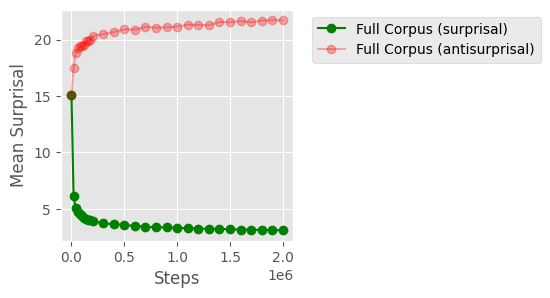

In [6]:
positives = get_avg_df([indiv_surprisals], column='MeanSurprisal')
negatives = get_avg_df([indiv_surprisals], column='MeanNegSurprisal')

plot_avg_pos_neg(positives, negatives, save_as='../corpus_surprisal.pdf')

In [7]:
surprisals = indiv_surprisals[['Steps', 'Token', 'MeanSurprisal', 'MeanNegSurprisal']].drop_duplicates().reset_index(drop=True)
surprisals = surprisals.merge(example_counts)
surprisals

,Steps,Token,MeanSurprisal,MeanNegSurprisal,Frequency
0,0,a,14.225594,14.234500,512
1,0,aa,15.597247,15.751283,16
2,0,abandon,15.298998,15.042455,1
3,0,abandoned,14.781739,14.788133,26
4,0,abandoning,14.522403,14.334804,1
...,...,...,...,...,...
263257,2000000,zone,4.706525,22.451706,20
263258,2000000,zones,2.175875,23.845009,5
263259,2000000,zoo,5.894639,15.055669,2
263260,2000000,zoom,2.738938,13.967112,2


In [8]:
categories = trend_categories(surprisals)
categories_df = pd.DataFrame(categories, index=['count', 'words']).transpose()

num_tokens = surprisals.Token.nunique()
categories_df['overall_prop'] = categories_df['count'].apply(lambda x: round((x * 100) / num_tokens, 1))
categories_df

,count,words,overall_prop
Decreasing-Increasing,8309,"[a, aa, abandon, abandoned, abandoning, abando...",91.5
Decreasing-Decreasing,487,"[abducted, abstract, academics, accommodations...",5.4
Increasing-Increasing,243,"[absorption, accelerating, accessibility, acci...",2.7
Increasing-Decreasing,39,"[arresting, banging, breakers, bump, caliber, ...",0.4


---
### Investigating the effect of **token frequency**

In [9]:
infreq_tokens = surprisals[surprisals.Frequency <= 10].Token.unique()
print(f"Number of infrequent (frequency ≤ 10) tokens in the word bank: {len(infreq_tokens)}")

Number of infrequent (frequency ≤ 10) tokens in the word bank: 7231


In [10]:
# proportion of the category covered by infrequent tokens
categories_df['cat_coverage'] = categories_df.words.apply(lambda x: round(len((set(x).intersection(infreq_tokens))) / len(x), 2))

# proportion (distribution) of infrequent tokens in each category
categories_df['infreq_prop'] = categories_df.words.apply(lambda x: round(len((set(x).intersection(infreq_tokens))) / len(infreq_tokens), 2))

categories_df

,count,words,overall_prop,cat_coverage,infreq_prop
Decreasing-Increasing,8309,"[a, aa, abandon, abandoned, abandoning, abando...",91.5,0.78,0.89
Decreasing-Decreasing,487,"[abducted, abstract, academics, accommodations...",5.4,1.00,0.07
Increasing-Increasing,243,"[absorption, accelerating, accessibility, acci...",2.7,0.99,0.03
Increasing-Decreasing,39,"[arresting, banging, breakers, bump, caliber, ...",0.4,1.00,0.01


In [11]:
def calculate_stats(word_list, word_freqs_df):
    frequencies = word_freqs_df[word_freqs_df['Token'].isin(word_list)]['Frequency']
    return pd.Series([int(frequencies.min()), int(frequencies.max()), int(frequencies.median()), round(frequencies.mean())],
                     index=['min_freq', 'max_freq', 'median_freq', 'rounded_mean_freq'])

categories_df[['min_freq', 'max_freq', 'median_freq', 'rounded_mean_freq']] = categories_df['words'].apply(
    lambda words: calculate_stats(words, surprisals)
)

categories_df = categories_df.reset_index().rename(columns={'index': 'trend_category'})
# categories_df.to_csv('../results/surp_antisurp_trends.csv', index=None)
categories_df

,trend_category,count,words,overall_prop,cat_coverage,infreq_prop,min_freq,max_freq,median_freq,rounded_mean_freq
0,Decreasing-Increasing,8309,"[a, aa, abandon, abandoned, abandoning, abando...",91.5,0.78,0.89,1,512,4,13
1,Decreasing-Decreasing,487,"[abducted, abstract, academics, accommodations...",5.4,1.00,0.07,1,10,1,2
2,Increasing-Increasing,243,"[absorption, accelerating, accessibility, acci...",2.7,0.99,0.03,1,18,1,2
3,Increasing-Decreasing,39,"[arresting, banging, breakers, bump, caliber, ...",0.4,1.00,0.01,1,2,1,1


In [17]:
# expanded_df = categories_df.explode('words')

# merged_df = pd.merge(expanded_df, surprisals, left_on='words', right_on='Token')

# # plt.title('Box Plot of Word Frequencies by Category')
# sns.boxplot(x='trend_category', y='Frequency', data=merged_df[merged_df.trend_category != 'Decreasing-Increasing'], showfliers=False)
# plt.xlabel('Category')
# plt.xticks(rotation=45)
# plt.savefig('../box_minority_trends.pdf', format='pdf', bbox_inches='tight')
# plt.show()

# sns.boxplot(x='trend_category', y='Frequency', data=merged_df[merged_df.trend_category == 'Decreasing-Increasing'], showfliers=False)
# plt.xlabel('Category')
# plt.savefig('../box_majority_trend.pdf', format='pdf', bbox_inches='tight')
# plt.show()

In [18]:
# plt.figure(figsize=(10, 6))
# sns.boxplot(x='trend_category', y='Frequency', data=merged_df, showfliers=False)
# plt.xlabel('Category')
# # plt.xticks(rotation=45)
# plt.savefig('../box_trends.pdf', format='pdf', bbox_inches='tight')
# plt.show()

In [14]:
overall_prop = categories_df[['trend_category', 'overall_prop']]
overall_prop

,trend_category,overall_prop
0,Decreasing-Increasing,91.5
1,Decreasing-Decreasing,5.4
2,Increasing-Increasing,2.7
3,Increasing-Decreasing,0.4


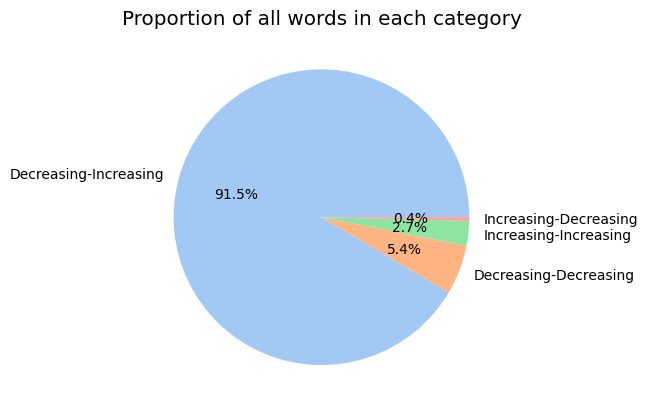

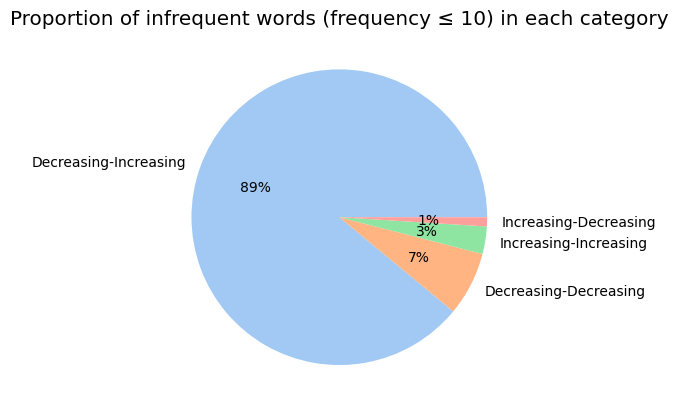

In [15]:
colors = sns.color_palette('pastel')[0:4]

plt.pie(categories_df['overall_prop'], labels=categories_df['trend_category'], colors=colors, autopct='%.1f%%')
plt.title('Proportion of all words in each category')
plt.show()

plt.pie(categories_df['infreq_prop'], labels=categories_df['trend_category'], colors=colors, autopct='%.f%%')
plt.title('Proportion of infrequent words (frequency ≤ 10) in each category')
plt.show()

Figure saved to ../trend_neg_corr.pdf


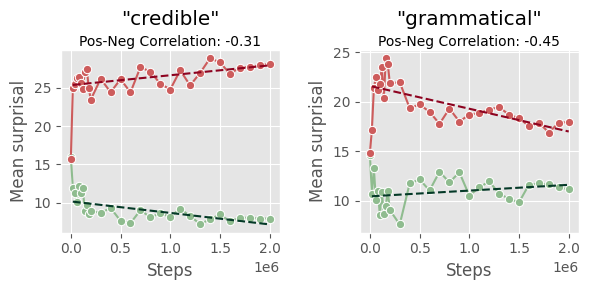

Figure saved to ../trend_pos_corr.pdf


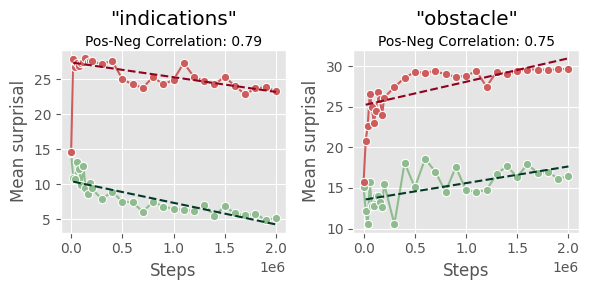

In [ ]:
# Decreasing-Increasing: 'flesh'/'banned'/'regain'/'heating', 
# Increasing-Decreasing: 'comical'/'jewellery'/'outdoor'/'grammatical'
# Decreasing-Decreasing: 'creature'/'indications'
# Increasing-Increasing: 'neighbourhoods'/'silly'/'brow'/'predictions'/'obstacle'

words = ['credible', 'grammatical']
plot_surprisals(words, indiv_surprisals, show_error_interval=True, neg_samples=True, fit_line=True, first_step=False, legend=False, save_as='../trend_neg_corr.pdf') 
words = ['indications', 'obstacle']
plot_surprisals(words, indiv_surprisals, show_error_interval=True, neg_samples=True, fit_line=True, first_step=False, legend=False, save_as='../trend_pos_corr.pdf')

---
### Investigating the effect of **POS** 

In [22]:
# Run to add a POS column to the surprisals file

# from modules import POS

# document = "../data/raw/wikitext103_test.txt"
# pos_tags = POS.get_tags(document)

# merged_df = pd.merge(surprisals, pos_tags, on='Token', how='inner')
# merged_df.to_csv('../results/surprisals_pos.csv', sep='\t', index=False)

In [34]:
surprisals_pos = pd.read_csv('../results/surprisals_pos.csv', sep='\t')
surprisals_pos

,Steps,Token,MeanSurprisal,MeanNegSurprisal,Frequency,POS
0,0,a,14.225594,14.234500,512,['DET']
1,0,aa,15.597247,15.751283,16,"['PROPN', 'NOUN']"
2,0,abandon,15.298998,15.042455,1,['VERB']
3,0,abandoned,14.781739,14.788133,26,['VERB']
4,0,abandoning,14.522403,14.334804,1,['VERB']
...,...,...,...,...,...,...
263257,2000000,zone,4.706525,22.451706,20,['NOUN']
263258,2000000,zones,2.175875,23.845009,5,['NOUN']
263259,2000000,zoo,5.894639,15.055669,2,"['PROPN', 'NOUN']"
263260,2000000,zoom,2.738938,13.967112,2,['NOUN']


In [59]:
categories = trend_categories(surprisals_pos)
categories_df = pd.DataFrame(categories, index=['count', 'words']).transpose()

num_tokens = surprisals_pos.Token.nunique()
categories_df['overall_prop'] = categories_df['count'].apply(lambda x: round((x * 100) / num_tokens, 1))
categories_df

,count,words,overall_prop
Decreasing-Increasing,8309,"[a, aa, abandon, abandoned, abandoning, abando...",91.5
Decreasing-Decreasing,487,"[abducted, abstract, academics, accommodations...",5.4
Increasing-Increasing,243,"[absorption, accelerating, accessibility, acci...",2.7
Increasing-Decreasing,39,"[arresting, banging, breakers, bump, caliber, ...",0.4


In [69]:
import ast
from collections import Counter

# Step 1: Create a mapping of words to their POS tags
word_to_pos = dict(zip(surprisals_pos['Token'], surprisals_pos['POS'].apply(ast.literal_eval)))
word_to_pos

# Step 2: Map tags to each word in `categories_df`
categories_df['tags'] = categories_df['words'].apply(
    lambda words: [tag for word in words if word in word_to_pos for tag in word_to_pos[word]]
)

# Step 3: Calculate total tags for each category
categories_df['total_tags'] = categories_df['tags'].apply(len)

# Step 4: Count individual tag occurrences
categories_df['tag_counts'] = categories_df['tags'].apply(lambda tags: Counter(tags))

# Step 5: Calculate proportions for each tag
unique_tags = set(tag for tags in categories_df['tags'] for tag in tags)
for tag in unique_tags:
    categories_df[tag] = categories_df['tag_counts'].apply(lambda counts: counts.get(tag, 0)) / categories_df['total_tags']

# Drop intermediate columns
categories_df = categories_df.drop(columns=['tags', 'tag_counts', 'total_tags'])

categories_df

,count,words,overall_prop,DET,CCONJ,INTJ,ADP,PART,AUX,PROPN,SCONJ,X,NUM,NOUN,ADJ,PRON,ADV,VERB
Decreasing-Increasing,8309,"[a, aa, abandon, abandoned, abandoning, abando...",91.5,0.001439,0.000775,0.000664,0.006861,0.000443,0.00343,0.045812,0.002545,0.000664,0.003984,0.468408,0.140865,0.005311,0.041496,0.277304
Decreasing-Decreasing,487,"[abducted, abstract, academics, accommodations...",5.4,0.000000,0.000000,0.001931,0.005792,0.000000,0.00000,0.027027,0.000000,0.000000,0.000000,0.544402,0.146718,0.001931,0.040541,0.231660
Increasing-Increasing,243,"[absorption, accelerating, accessibility, acci...",2.7,0.000000,0.000000,0.000000,0.003906,0.000000,0.00000,0.031250,0.000000,0.000000,0.003906,0.468750,0.164062,0.000000,0.031250,0.296875
Increasing-Decreasing,39,"[arresting, banging, breakers, bump, caliber, ...",0.4,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.487179,0.179487,0.025641,0.025641,0.282051


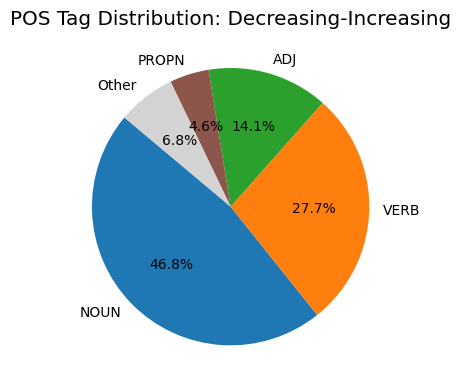

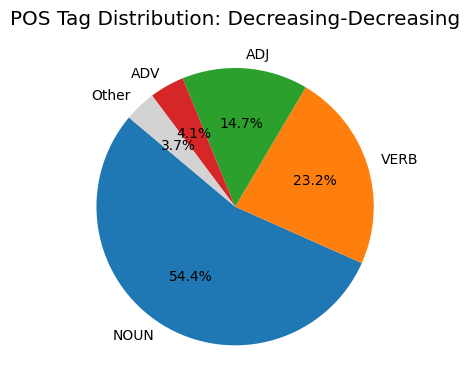

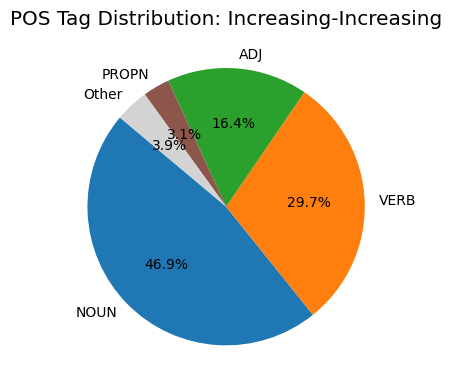

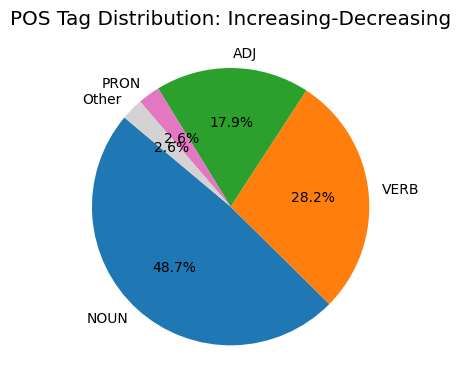

In [ ]:
# Define a consistent color mapping for POS tags
tag_colors = {
    'NOUN': '#1f77b4',
    'VERB': '#ff7f0e',
    'ADJ': '#2ca02c',
    'ADV': '#d62728',
    'DET': '#9467bd',
    'PROPN': '#8c564b',
    'PRON': '#e377c2',
    'ADP': '#7f7f7f',
    'CONJ': '#bcbd22',
    'SCONJ': '#17becf',
    'NUM': '#aec7e8',
    'AUX': '#ffbb78',
    'PART': '#98df8a',
    'INTJ': '#ff9896',
    'X': '#c5b0d5'
}

# Function to generate pie charts
for idx, row in categories_df.iterrows():
    category_name = row.name
    proportions = {tag: row[tag] for tag in unique_tags if row[tag] > 0}
    
    # Sort tags by their proportions and highlight the top 4
    sorted_tags = sorted(proportions.items(), key=lambda x: x[1], reverse=True)
    top_tags = dict(sorted_tags[:4])
    other_tags = dict(sorted_tags[4:])
    if other_tags:
        top_tags['Other'] = sum(other_tags.values())

    colors = [tag_colors.get(tag, '#d3d3d3') for tag in top_tags.keys()]  # Default to gray if tag not in tag_colors

    plt.figure(figsize=(4, 4))
    plt.pie(
        top_tags.values(),
        labels=top_tags.keys(),
        autopct='%1.1f%%',
        startangle=140,
        colors=colors,
    )
    plt.title(f"POS Tag Distribution: {category_name}")
    plt.tight_layout()
    plt.show()


In [ ]:
import pandas as pd
import pickle

data = 